Punto 1

In [1]:
import os
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [78]:
#llamar datos de la carpeta data; dirBase, ciudad &origenData =Str 

def llamarDatos(ciudad, origenData):
    serie=os.path.join('.','data',ciudad,origenData+'.csv')
    serie_pd = pd.read_csv(serie, sep = ';',encoding='latin-1')
    return serie_pd

ciudades: Barranquilla, Cali,
          Carmendebolivar, Medellin,
          SantaMarta, Sucre, Uribia, Valledupar
          
origenesData: IDEAM, NREL

In [94]:
#Calcular la energía total al mes
def ghiMensual(serie):
    agnos=sorted (serie['AÑO'].unique()) #sorted() organiza los datos de menor a mayot
    nombre_energia = list(serie)[-1] #list [x](i) toma el primer valor de la columna i del dataFrame X
    DefinitiveDataFrame =pd.DataFrame(columns=["AÑO","MES","DIAS","GHIMensual","GHIdiarioPromedio"+nombre_energia]) #Construyo el nuevo DataFrame
    for agno in agnos:
        for mes in range (1,13): #range() no toma el último valor
            dias=sorted(serie[(serie['AÑO']==agno)&(serie['MES']==mes)]['DIA'].unique()) #tomo el número de dias por mes
            ghiMensual=serie.loc[((serie['AÑO']==agno)&(serie['MES']==mes)),nombre_energia].sum()/1000 #calculo la suma de la energia mensual en kWh
            #serie.loc[cond,'x'] me toma los valores de la columna 'x' de un dataframe dada una condicion
            ghiDiario=ghiMensual/dias[-1] #Calculo del valor diario promedio mensual            
            ghi=dict([("AÑO",agno),("MES",mes),("DIAS",dias[-1]),("GHIMensual",ghiMensual),("GHIdiarioPromedio"+nombre_energia,ghiDiario)]) #retorna una lista: {Mes:x,DIAS:y,etc}
            DefinitiveDataFrame=DefinitiveDataFrame.append(ghi, ignore_index=True) #Guardo mis datos en el DataFrame ignore_index ignora los labels de los datos
    return DefinitiveDataFrame

In [89]:
def enficc(serie):
    percentil=0.01
    en= ghiMensual(serie).quantile(q=percentil,numeric_only=True)["GHIdiarioPromedio"]
    return 'La ENFICC 99% es: ',en

In [90]:
serie=llamarDatos("Barranquilla","IDEAM")
enficc(serie)

('La ENFICC 99% es: ', 4.1605902581736194)

Punto Número 2

In [6]:
def graficar(ciudad1,ciudad2,ciudad3,origenData):
    data1=sorted(ghiMensual(ciudad1,origenData)["GHIdiarioPromedio"])
    data2=sorted(ghiMensual(ciudad2,origenData)["GHIdiarioPromedio"])
    data3=sorted(ghiMensual(ciudad3,origenData)["GHIdiarioPromedio"])
    numdatos1=range(len(data1))
    numdatos2=range(len(data2))
    numdatos3=range(len(data3))
    fig=figure()
    pylab.xlabel("Datos")
    pylab.ylabel("Energía/Energía Base")
    pylab.title(origenData)
    pylab.plot(numdatos1,data1/data1[0],'-k', label=ciudad1)
    pylab.plot(numdatos2,data2/data2[0],'-y', label=ciudad2)
    pylab.plot(numdatos3,data3/data3[0],'-r', label=ciudad3)
    pylab.legend(loc='upper left')
    return



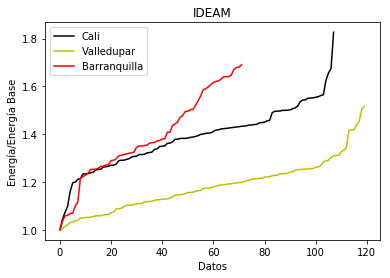

In [7]:
graficar("Cali","Valledupar","Barranquilla","IDEAM")

Punto 3

In [118]:
#OJO, datos satelitales son IDEAM, datos reales son NREL
#Seleccionar pedazos de series
def serieObj (agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad):
    origen="NREL"
    x=llamarDatos(ciudad,origen)[(llamarDatos(ciudad,origen)['AÑO']>=agnoInicial)&
                               (llamarDatos(ciudad,origen)['MES']>=mesInicial)&
                               (llamarDatos(ciudad,origen)['AÑO']<=agnoFinal)&
                               (llamarDatos(ciudad,origen)['MES']<=mesFinal)]
    return x
def serieRef (agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad):
    origen="IDEAM"
    y=llamarDatos(ciudad,origen)[(llamarDatos(ciudad,origen)['AÑO']>=agnoInicial)&
                               (llamarDatos(ciudad,origen)['MES']>=mesInicial)&
                               (llamarDatos(ciudad,origen)['AÑO']<=agnoFinal)&
                               (llamarDatos(ciudad,origen)['MES']<=mesFinal)]
    return y
def MCP (agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad):
    #Parámetros para calcular MCP
    Ref=serieRef (agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad)['IDEAM']
    Obj=serieObj (agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad)['NREL']
    GHImean_Ref=Ref.sum()/count_nonzero(Ref)
    GHImean_Obj=Obj.sum()/count_nonzero(Obj)
    DSTD_Ref=Ref[Ref!=0].std()
    DSTD_Obj=Obj[Obj!=0].std()
    relDSTDs=DSTD_Obj/DSTD_Ref
    #corrección
    refLarga=llamarDatos(ciudad,"IDEAM")['IDEAM']
    A=GHImean_Obj-(relDSTDs*GHImean_Ref)
    B=relDSTDs*refLarga
    df=llamarDatos(ciudad,"IDEAM")
    df["MCP"]=A+B
    return df
def plotPorCiudad (agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad):
    Corregida=ghiMensual(MCP(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad))['GHIMensual']
    Satelitales=ghiMensual(llamarDatos(ciudad,"IDEAM"))['GHIMensual']
    x=range(len(Corregida))
    fig=figure()
    pylab.xlabel("Meses")
    pylab.ylabel(r'$GHI[\frac{W}{m^2}]$')
    pylab.plot(x,Satelitales,'-k', label="Datos Satelitales")
    pylab.plot(x,Corregida,'-r', label="Datos Corregidos" )
    pylab.legend(loc='upper left')
    return

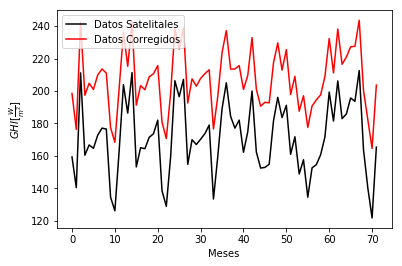

In [119]:
plotPorCiudad(2007,1,2015,1,"Barranquilla")

Punto 4